# Example of a single spectrum fit.

## First step: loading the data cube

In [30]:
# import base class for the manipulation of a SITELLE spectral cube: HDFCube
from orcs.process import SpectralCube
import pylab as pl
from importlib import reload
import orcs.process
import orb.core

In [34]:
# load spectral cube
reload(orb.core)
reload(orb.fft)
reload(orb.cube)
reload(orcs.core)
reload(orcs.fit)
reload(orcs.process)
cube = SpectralCube('/home/thomas/M31_SN3.merged.cm1.1.0.hdf5')
cube.set_param('flambda') = cube.comp

2to3.7028|INFO| Closing parallel processing server
2to3.7028|INFO| shape: (2048, 2064, 840)
2to3.7028|INFO| wavenumber calibration: True
2to3.7028|INFO| flux calibration: True
2to3.7028|INFO| wcs calibration: True
2to3.7028|INFO| parallel processing closed


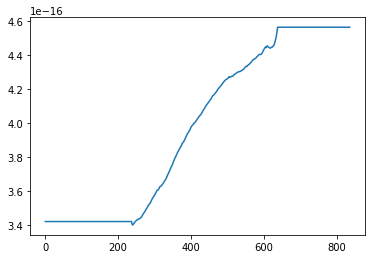

In [39]:
import numpy as np
pl.plot(cube.params.flambda)

2to3.7028|INFO| mean flambda config: 1.4984303888958248e-16
2to3.7028|INFO| standard_spectrum not set: no relative vector correction computed
2to3.7028|INFO| standard_path not set: no relative vector correction computed
2to3.7028|INFO| standard_image not set: no absolute vector correction computed


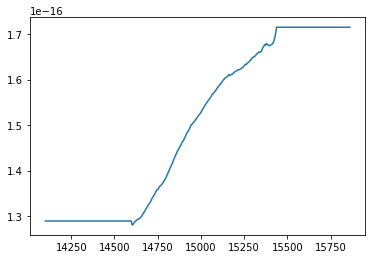

In [41]:
cube.compute_flambda().plot()

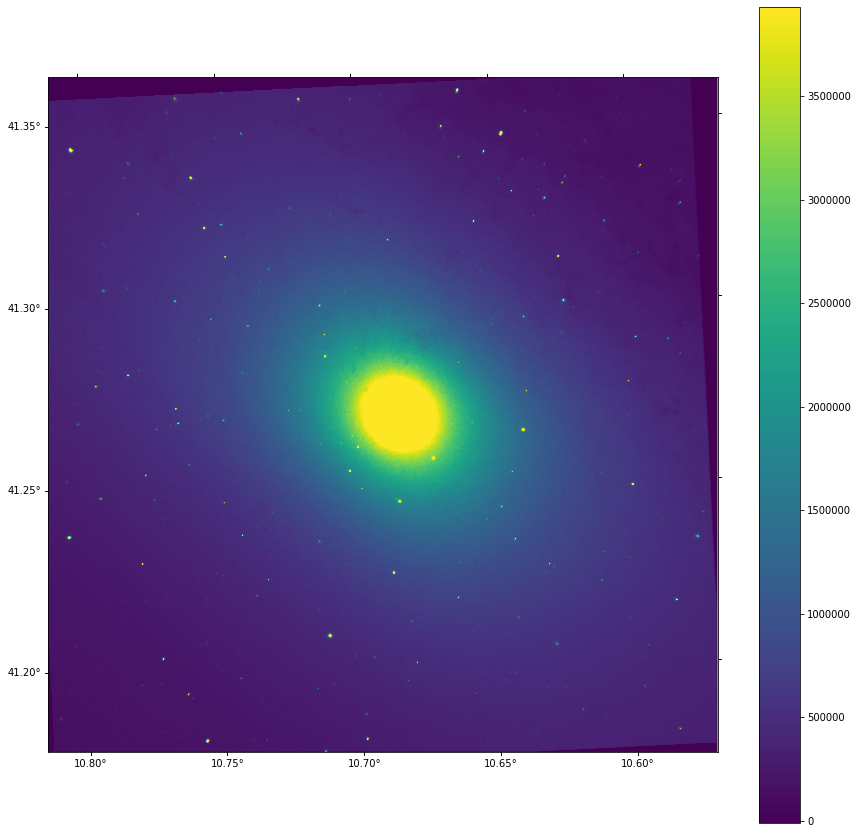

In [7]:
# Deep frame (in counts) 
deep = cube.get_deep_frame()
deep.imshow()
pl.colorbar()

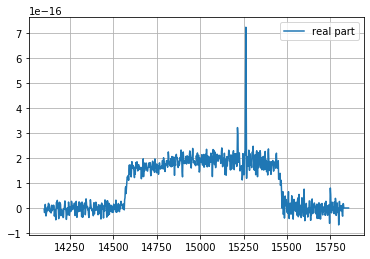

In [22]:
# extract and plot a spectrum at x=919 y=893 integrated over a radius of 2 pixels
spectrum = cube.get_spectrum(919, 893, 2, mean_flux=True)
#spectrum = cube.get_spectrum(1800, 250, 20, mean_flux=True)
spectrum.plot(plot_imag=False)
pl.legend()
pl.grid()

The returned spectrum is a `RealSpectrum` object which provides many internal methods, one of which is the ability to fit directly. 

* plot: `spectrum.plot` (by default the real and the imaginary part of the spectrum are displayed, but you can dispaly only the real part with the option: `plot_imag=False`)
* fit: `spectrum.fit`

If you want to get the data and the corresponding axis as numpy.ndarray you can do it this way :

* data: `spectrum.data`
* axis: `spectrum.axis.data`

In [23]:
print('object type:', spectrum)
print('data as numpy.ndarray vector', type(spectrum.data))
print('axis (in cm-1) as numpy.ndarray vector', type(spectrum.axis.data))

object type: <orb.fft.RealSpectrum object at 0x7efc833fe5d0>
data as numpy.ndarray vector <class 'numpy.ndarray'>
axis (in cm-1) as numpy.ndarray vector <class 'numpy.ndarray'>


## Second step: fitting the spectrum

* The emission lines to fit are passed by name (their wavenumber, in cm-1, could also be given directly). 
  Remember that:
  
  $\sigma [\text{cm}^{-1}] = \frac{1e7}{\lambda [\text{nm}]}$
  
  
  
* The line model is `gaussian` by default. Here we use the more realistic model of a cardinal sinus convoluted with a gaussian `sincgauss`:
  
  ```python
  fmodel = 'sinc'
  ```


* The velocity of the lines is -513 km/s. It is passed with the argument:

  ```python
  pos_cov = -513`,
  pos_def = ['1','1']
  ```
  

  The velocity is considered as a covarying parameter. By default all the lines are considered to have a free velocity parameter. If we want to set the same velocity to all the lines we must set the definition of the position of eachline to the same covaying group with `pos_def = ['1','1']`.



In [24]:
fit_res = spectrum.fit(['Halpha', '[NII]6583'],
                       fmodel='sinc',
                       pos_cov=(-513,),
                       pos_def=['1', '1'])
print('\n===== Results ======')
print('Velocity: ', fit_res['velocity_gvar'])
print('Flux: ', fit_res['flux_gvar'] )
print('====================')

2to3.7028|WARNING| /home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)




===== Results ======
Velocity:  [-508.3(1.2) -508.3(1.2)]
Flux:  [6.10(28)e-16 1.62(28)e-16]


### Ungroup the velocity parameter

We can ungroup the velocity of the emission lines by giving each line a unique group label. We can set:
  
  `pos_def=['1', '2']`
  
I this case the measured velocity must be different for both lines. But the precision will also be worsen.


In [25]:
fit_res = spectrum.fit(['Halpha', '[NII]6583'],
                       fmodel='sinc',
                       pos_cov=(-513, -513),
                       pos_def=['1', '2'])
print('\n===== Results ======')
print('Velocity: ', fit_res['velocity_gvar'])
print('Flux: ', fit_res['flux_gvar'] )
print('====================')

2to3.7028|WARNING| /home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)




===== Results ======
Velocity:  [-507.7(1.3) -517.6(4.8)]
Flux:  [6.11(28)e-16 1.68(28)e-16]


### using a sincgauss model with a single broadening parameter

We can try the broadened sincgauss model (sinc instrumental function convoluted with a gaussian). We can group the broadening parameter of the emission lines by giving the same group label to the lines. We can set:
  
  ```python
  fmodel='sincgauss',
  sigma_def=['1', '1'],
  sigma_cov=20
  ```
  
I this case the measured broadening will be the same for both lines and the precision of the estimations are better.
Note that the broadening must be initialized to a nonzero value for the fit to work `sigma_cov=20`

In [27]:
fit_res = spectrum.fit(
    ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=(-513,),
    pos_def=['1', '1'],
    sigma_def=['1', '1'],
    sigma_cov=(20,))
print('\n===== Results ======')
print('Velocity: ', fit_res['velocity_gvar'])
print('Broadening: ', fit_res['broadening_gvar'])
print('Flux: ', fit_res['flux_gvar'] )
print('====================')


===== Results ======
Velocity:  [-507.1(1.6) -507.1(1.6)]
Broadening:  [27.4(1.9) 27.4(1.9)]
Flux:  [8.97(54)e-16 2.51(38)e-16]


### Plotting the result

In [28]:
spectrum.plot(label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.xlim((14500, 15500))

TypeError: plot() got an unexpected keyword argument 'label'

### Model with no filter

The filter model can be removed but the range over which the fit is made must be limited to the filter bandpass. This is made transparently by setting the option

`nofilter = True`


INFO| Number of integrated pixels: 13


 [==========] [100%] [completed in 0.025 s]                                   

INFO| Number of integrated pixels: 13
INFO| Init of the parallel processing server with 4 threads



 [==========] [100%] [completed in 0.443 s]                                   

===== Results ======
Velocity:  [-506.4(1.5) -506.4(1.5)]
Broadening:  [26.2(1.8) 26.2(1.8)]
Flux:  [1.676(98)e-15 4.47(68)e-16]


(14500, 15500)

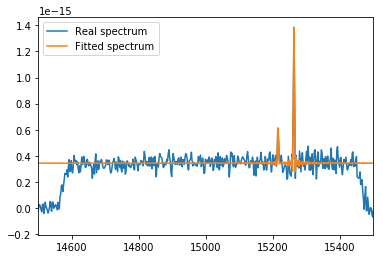

INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Init of the parallel processing server with 4 threads
INFO| Number of integrated pixels: 13
IN

In [12]:
axis, spectrum, fit_res = cube.fit_lines_in_spectrum(
    919, 893, 2, ['Halpha', '[NII]6583'],
    fmodel='sincgauss',
    pos_cov=-513,
    pos_def=['1', '1'],
    sigma_def=['1', '1'],
    sigma_cov=20,
    nofilter=True)
print '\n===== Results ======'
print 'Velocity: ', fit_res['velocity_gvar']
print 'Broadening: ', fit_res['broadening_gvar'] 
print 'Flux: ', fit_res['flux_gvar'] 
print '===================='
pl.plot(axis, spectrum, label='Real spectrum')
pl.plot(axis, fit_res['fitted_vector'], label='Fitted spectrum')
pl.legend()
pl.xlim((14500, 15500))
# Flux:  [1.676(98)e-15 4.47(68)e-16]